In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

<Figure size 360x288 with 0 Axes>

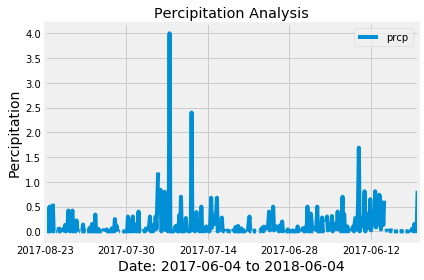

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from today

last_yr_date = dt.date(2018, 6, 4) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores

precipitation = session.query(Measurement.prcp, Measurement.date)\
    .filter( Measurement.date >= last_yr_date)\
    .order_by(Measurement.date.desc()).all()

# Save the query results as a Pandas DataFrame and set the index to the date column

prcp_df = pd.DataFrame(precipitation, columns=['prcp', 'date'])

# Sort the dataframe by date

prcp_df.sort_values(['date'])

# Use Pandas Plotting with Matplotlib to plot the data

fig1 = plt.figure(figsize=(5,4))
prcp_df.plot('date', 'prcp')
plt.grid(True)
plt.xlabel("Date: 2017-06-04 to 2018-06-04", fontsize=14)
plt.ylabel("Percipitation", fontsize=14)
plt.title("Percipitation Analysis")
plt.legend
plt.tight_layout()
plt.show()
plt.close(fig1)


![precipitation](Images/precipitation.png)

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,prcp
count,412.000000
mean,0.117549
std,0.294210
min,0.000000
25%,0.000000
50%,0.020000
75%,0.120000
max,4.000000


In [12]:
# How many stations are available in this dataset?
session.query(Measurement).group_by(Measurement.station).count()

9

In [13]:
# What are the most active stations?
# List the stations and the counts in descending order.
active = session.query(Measurement.station, func.count(Measurement.tobs))\
    .group_by(Measurement.station)\
    .order_by(func.count(Measurement.tobs)\
    .desc()).all()
most_active = active[0][0]
most_active

'USC00519281'

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
temperatures = session.query(Measurement.station, Measurement.date, Measurement.tobs)\
    .filter(Measurement.station == most_active)\
    .filter(Measurement.date > last_yr_date)\
    .order_by(Measurement.date).all()
most_active_temp = pd.DataFrame(temperatures, columns=['station', 'date', 'temp'])
lowest_temp = most_active_temp['temp'].min()
highest_temp = most_active_temp['temp'].max()
avg_temp = most_active_temp['temp'].mean()
avg_temp = round(avg_temp, 2)

print(f"The lowest temperature recorded was {lowest_temp}F" +'\n'+
      f"The highest temperature recorded was {highest_temp}F" +'\n'+
      f"The average temperature recorded was {avg_temp}F")

The lowest temperature recorded was 69.0F
The highest temperature recorded was 83.0F
The average temperature recorded was 76.11F


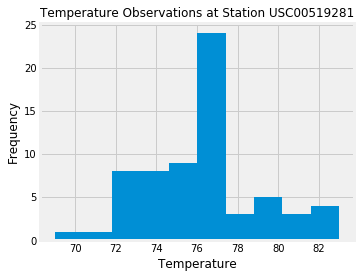

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
fig2 = plt.figure(figsize=(5,4))
plt.grid(True)
plt.hist(most_active_temp['temp'])
bin_size = 12
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title('Temperature Observations at Station USC00519281', fontsize = 12)
plt.show()
plt.close(fig2)

In [16]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_avg_temp = (calc_temps('2016-06-04', '2016-06-24'))

yerr_val = trip_avg_temp[0][2] - trip_avg_temp[0][0]
y = [trip_avg_temp[0][1]]
x = 0

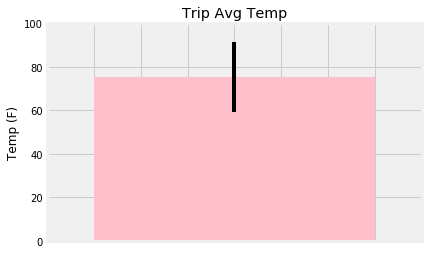

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig3 = plt.figure(figsize = (5,4))
fig, ax = plt.subplots()

ax.set_ylabel("Temp (F)")
ax.set_title("Trip Avg Temp")

ax.bar(x, y, width=1.5, color="pink", yerr=yerr_val)
ax.set_xlim(0, 1)
ax.set_ylim(0, 100)
ax.set_xbound(lower=-1, upper=1)
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) 
plt.close(fig3)
plt.show()

In [19]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

start_date = '2012-01-01'
end_date = '2012-01-07'

sel = [Station.station, Station.name, Station.latitude,
      Station.longitude, Station.elevation, func.sum(Measurement.prcp)]

results = session.query(*sel).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= start_date).\
    filter(Measurement.date <= end_date).\
    group_by(Station.name).order_by(func.sum(Measurement.prcp).desc()).all()
print(results)

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.31), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.25), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.1), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.060000000000000005), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
trip_start = '2018-01-01'
trip_end = '2018-01-08'

# Use the start and end date to create a range of dates
trip_dur = pd.date_range(trip_start, trip_end, freq='D')

# Stip off the year and save a list of %m-%d strings
trip_month_day = trip_dur.strftime('%m-%d')

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []
for date in trip_month_day:
    normals.append(*daily_normals(date))
    
normals

[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0),
 (57.0, 67.16071428571429, 75.0)]

In [23]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df = pd.DataFrame(normals, columns=['tmin', 'tavg', 'tmax'])
df['date'] = trip_dur
df.set_index(['date'])

,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0
2018-01-06,61.0,68.964912,76.0
2018-01-07,57.0,68.543860,76.0
2018-01-08,57.0,67.160714,75.0


In [30]:
df.index = pd.to_datetime(df.index)

In [32]:
# Plot the daily normals as an area plot with `stacked=False`
#df.plot(kind='area', stacked=False, x_compat=True, alpha=.2)